# Imports

In [3]:
import pandas as pd
#import psycopg2

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap

In [4]:
data_simulator = pd.read_csv("data_simulator.csv", index_col=0) 
data_gta = pd.read_csv("data_gta.csv", index_col=0) 
data_simulator.index = pd.to_datetime(data_simulator.index)
data_gta.index = pd.to_datetime(data_gta.index)
pd.options.display.max_columns = None

In [5]:
data_gta.head(5)

,time,session_id,scenario,Pos_X,Pos_Y,hadCollision,pedId,nextPedRunning,distancePed,speed,posPedX,posPedY,currentDistance
2017-10-04 12:46:18.071232,2017-10-04 12:46:18.071232,144,7,-975.749500,82.249620,0.0,17.0,0.0,70.352844,0.000000,154.0415,-23.48739,1253.50293
2017-10-04 12:46:18.258732,2017-10-04 12:46:18.258732,144,7,-975.703735,82.260506,0.0,17.0,0.0,70.352844,0.021795,154.0415,-23.48739,1253.45900
2017-10-04 12:46:18.279286,2017-10-04 12:46:18.279286,144,7,-975.707031,82.254620,0.0,17.0,0.0,70.352844,0.137319,154.0415,-23.48739,1253.46167
2017-10-04 12:46:18.298839,2017-10-04 12:46:18.298839,144,7,-975.708100,82.252920,0.0,17.0,0.0,70.352844,0.128202,154.0415,-23.48739,1253.46265
2017-10-04 12:46:18.315884,2017-10-04 12:46:18.315884,144,7,-975.709534,82.251180,0.0,17.0,0.0,70.352844,0.137845,154.0415,-23.48739,1253.46400


In [6]:
data_simulator.head(5)

,time2,session_id,scenario,steering,brake,throttle
2017-10-04 12:46:17.848640,2017-10-04 12:46:17.848640,144,1,33096.0,65535.0,65535.0
2017-10-04 12:46:17.868694,2017-10-04 12:46:17.868694,144,1,33096.0,65535.0,65535.0
2017-10-04 12:46:17.888776,2017-10-04 12:46:17.888776,144,1,33096.0,65535.0,65535.0
2017-10-04 12:46:17.908800,2017-10-04 12:46:17.908800,144,1,33096.0,65535.0,65535.0
2017-10-04 12:46:17.928867,2017-10-04 12:46:17.928867,144,1,33096.0,65535.0,65535.0


In [7]:
#data_simulator['time2'] = pd.to_datetime(data_simulator['time2'])
#data_gta['time'] = pd.to_datetime(data_gta['time'])
freq_resample = '50000U'
data_simulator = data_simulator.resample(freq_resample).ffill()
data_gta = data_gta.resample(freq_resample).ffill()

In [8]:
data_gta.head(5)

,time,session_id,scenario,Pos_X,Pos_Y,hadCollision,pedId,nextPedRunning,distancePed,speed,posPedX,posPedY,currentDistance
2017-10-04 12:46:18.050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-04 12:46:18.100,2017-10-04 12:46:18.071232,144.0,7.0,-975.7495,82.24962,0.0,17.0,0.0,70.352844,0.0,154.0415,-23.48739,1253.50293
2017-10-04 12:46:18.150,2017-10-04 12:46:18.071232,144.0,7.0,-975.7495,82.24962,0.0,17.0,0.0,70.352844,0.0,154.0415,-23.48739,1253.50293
2017-10-04 12:46:18.200,2017-10-04 12:46:18.071232,144.0,7.0,-975.7495,82.24962,0.0,17.0,0.0,70.352844,0.0,154.0415,-23.48739,1253.50293
2017-10-04 12:46:18.250,2017-10-04 12:46:18.071232,144.0,7.0,-975.7495,82.24962,0.0,17.0,0.0,70.352844,0.0,154.0415,-23.48739,1253.50293


In [9]:
data_simulator.head(5)

,time2,session_id,scenario,steering,brake,throttle
2017-10-04 12:46:17.800,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-04 12:46:17.850,2017-10-04 12:46:17.848640,144.0,1.0,33096.0,65535.0,65535.0
2017-10-04 12:46:17.900,2017-10-04 12:46:17.888776,144.0,1.0,33096.0,65535.0,65535.0
2017-10-04 12:46:17.950,2017-10-04 12:46:17.948906,144.0,1.0,33096.0,65535.0,65535.0
2017-10-04 12:46:18.000,2017-10-04 12:46:17.988512,144.0,1.0,33096.0,65535.0,65535.0


In [10]:
data_simulator.drop('session_id', axis=1, inplace=True, errors='ignore') 
data_simulator.drop('scenario', axis=1, inplace=True, errors='ignore')
df_joined = pd.concat([data_gta, data_simulator], axis=1, join='inner')
df_joined = df_joined.dropna()
df_joined.head(5)

,time,session_id,scenario,Pos_X,Pos_Y,hadCollision,pedId,nextPedRunning,distancePed,speed,posPedX,posPedY,currentDistance,time2,steering,brake,throttle
2017-10-04 12:46:18.100,2017-10-04 12:46:18.071232,144.0,7.0,-975.7495,82.24962,0.0,17.0,0.0,70.352844,0.000000,154.0415,-23.48739,1253.50293,2017-10-04 12:46:18.088780,33096.0,65535.0,65535.0
2017-10-04 12:46:18.150,2017-10-04 12:46:18.071232,144.0,7.0,-975.7495,82.24962,0.0,17.0,0.0,70.352844,0.000000,154.0415,-23.48739,1253.50293,2017-10-04 12:46:18.148940,33096.0,65535.0,65535.0
2017-10-04 12:46:18.200,2017-10-04 12:46:18.071232,144.0,7.0,-975.7495,82.24962,0.0,17.0,0.0,70.352844,0.000000,154.0415,-23.48739,1253.50293,2017-10-04 12:46:18.188544,33096.0,65535.0,65535.0
2017-10-04 12:46:18.250,2017-10-04 12:46:18.071232,144.0,7.0,-975.7495,82.24962,0.0,17.0,0.0,70.352844,0.000000,154.0415,-23.48739,1253.50293,2017-10-04 12:46:18.248732,33096.0,65535.0,65535.0
2017-10-04 12:46:18.300,2017-10-04 12:46:18.298839,144.0,7.0,-975.7081,82.25292,0.0,17.0,0.0,70.352844,0.128202,154.0415,-23.48739,1253.46265,2017-10-04 12:46:18.288812,33096.0,65535.0,65535.0


## Clean Data

In [11]:
df_joined = df_joined[(df_joined.pedId != 16)  & (df_joined.pedId != 17)  & (df_joined.speed > 0)  & (df_joined.scenario != 7) & (df_joined.scenario != 8)]
df_joined.head(5)

,time,session_id,scenario,Pos_X,Pos_Y,hadCollision,pedId,nextPedRunning,distancePed,speed,posPedX,posPedY,currentDistance,time2,steering,brake,throttle
2017-10-04 12:50:28.400,2017-10-04 12:50:28.383484,144.0,1.0,-975.703700,82.260376,0.0,1.0,0.0,89.979675,0.013278,-885.6892,70.21315,1253.45900,2017-10-04 12:50:28.384988,32307.0,65535.0,65535.0
2017-10-04 12:50:28.450,2017-10-04 12:50:28.437127,144.0,1.0,-975.709534,82.251080,0.0,1.0,0.0,89.984790,0.135856,-885.6892,70.21315,1253.46400,2017-10-04 12:50:28.444647,32307.0,65535.0,65535.0
2017-10-04 12:50:28.500,2017-10-04 12:50:28.494279,144.0,1.0,-975.714233,82.246090,0.0,1.0,0.0,89.988880,0.125762,-885.6892,70.21315,1253.46814,2017-10-04 12:50:28.484754,32307.0,65535.0,65535.0
2017-10-04 12:50:28.550,2017-10-04 12:50:28.520850,144.0,1.0,-975.716000,82.244156,0.0,1.0,0.0,89.990330,0.102796,-885.6892,70.21315,1253.46960,2017-10-04 12:50:28.544914,32307.0,65535.0,65535.0
2017-10-04 12:50:28.600,2017-10-04 12:50:28.584519,144.0,1.0,-975.718100,82.241540,0.0,1.0,0.0,89.991715,0.047856,-885.6892,70.21315,1253.47168,2017-10-04 12:50:28.585020,32307.0,65535.0,65535.0


In [12]:
df_joined.drop_duplicates(keep=False,inplace=True) 

In [13]:
df_joined['acceleration'] = df_joined['speed'].diff()
df_joined['steeringOriginal'] = df_joined['steering']
df_joined['steering'] = df_joined['steering'].divide(65535)
df_joined['brake'] = df_joined['brake'].divide(65535)
df_joined['throttle'] = df_joined['throttle'].divide(65535)
df = df_joined.groupby(['session_id', 'scenario', 'pedId'], as_index=False).count()
print(df.shape)

(702, 19)


In [14]:
df = df[(df.time >= 200)][['session_id', 'scenario', 'pedId']]
print(df.shape)

(531, 3)


In [15]:
df_joined = df_joined.merge(df.drop_duplicates(), on=['session_id', 'scenario', 'pedId'], 
                   how='left', indicator=True)
df_joined = df_joined[df_joined._merge == 'both']

In [16]:
df = df_joined.groupby(['session_id', 'scenario', 'pedId'], as_index=False).count()
print(df.shape)

(531, 20)


In [17]:
#df_joined.drop('_merge', axis=1, inplace=True, errors='ignore') 

df_joined.head()

,time,session_id,scenario,Pos_X,Pos_Y,hadCollision,pedId,nextPedRunning,distancePed,speed,posPedX,posPedY,currentDistance,time2,steering,brake,throttle,acceleration,steeringOriginal,_merge
0,2017-10-04 12:50:28.383484,144.0,1.0,-975.703700,82.260376,0.0,1.0,0.0,89.979675,0.013278,-885.6892,70.21315,1253.45900,2017-10-04 12:50:28.384988,0.492973,1.0,1.0,NaN,32307.0,both
1,2017-10-04 12:50:28.437127,144.0,1.0,-975.709534,82.251080,0.0,1.0,0.0,89.984790,0.135856,-885.6892,70.21315,1253.46400,2017-10-04 12:50:28.444647,0.492973,1.0,1.0,0.122578,32307.0,both
2,2017-10-04 12:50:28.494279,144.0,1.0,-975.714233,82.246090,0.0,1.0,0.0,89.988880,0.125762,-885.6892,70.21315,1253.46814,2017-10-04 12:50:28.484754,0.492973,1.0,1.0,-0.010094,32307.0,both
3,2017-10-04 12:50:28.520850,144.0,1.0,-975.716000,82.244156,0.0,1.0,0.0,89.990330,0.102796,-885.6892,70.21315,1253.46960,2017-10-04 12:50:28.544914,0.492973,1.0,1.0,-0.022966,32307.0,both
4,2017-10-04 12:50:28.584519,144.0,1.0,-975.718100,82.241540,0.0,1.0,0.0,89.991715,0.047856,-885.6892,70.21315,1253.47168,2017-10-04 12:50:28.585020,0.492973,1.0,1.0,-0.054940,32307.0,both


# Set time

In [18]:
df_joined = df_joined.groupby(['session_id', 'scenario', 'pedId'], as_index=False).tail(200)

df_joined

,time,session_id,scenario,Pos_X,Pos_Y,hadCollision,pedId,nextPedRunning,distancePed,speed,posPedX,posPedY,currentDistance,time2,steering,brake,throttle,acceleration,steeringOriginal,_merge
108,2017-10-04 12:50:33.830479,144.0,1.0,-954.410900,85.53538,0.0,1.0,0.0,68.920520,9.671219,-885.689200,70.211080,1232.80957,2017-10-04 12:50:33.845520,0.515938,1.0,0.682551,0.098713,33812.0,both
109,2017-10-04 12:50:33.868080,144.0,1.0,-954.037500,85.53811,0.0,1.0,0.0,68.548940,9.764482,-885.689200,70.211080,1232.44031,2017-10-04 12:50:33.885626,0.513680,1.0,0.682551,0.093263,33664.0,both
110,2017-10-04 12:50:33.944784,144.0,1.0,-953.286100,85.54110,0.0,1.0,0.0,67.801056,9.948925,-885.689200,70.211080,1231.69678,2017-10-04 12:50:33.945787,0.510445,1.0,0.682551,0.184443,33452.0,both
111,2017-10-04 12:50:33.983888,144.0,1.0,-952.890869,85.54154,0.0,1.0,0.0,67.407620,10.044292,-885.689200,70.211080,1231.30566,2017-10-04 12:50:33.985893,0.509041,1.0,0.682551,0.095367,33360.0,both
112,2017-10-04 12:50:34.022992,144.0,1.0,-952.502500,85.54130,0.0,1.0,0.0,67.020960,10.137020,-885.689200,70.211080,1230.92114,2017-10-04 12:50:34.045552,0.508919,1.0,0.682551,0.092728,33352.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271234,2017-10-10 12:36:50.795825,175.0,3.0,246.223770,-73.10784,0.0,18.0,1.0,38.265724,12.308476,216.603561,-47.878265,72.62714,2017-10-10 12:36:50.793819,0.499321,1.0,1.000000,-0.218658,32723.0,both
271235,2017-10-10 12:36:50.833425,175.0,3.0,246.656800,-73.25378,0.0,18.0,1.0,38.910340,12.163155,216.603561,-47.878265,72.50171,2017-10-10 12:36:50.833926,0.501961,1.0,1.000000,-0.145322,32896.0,both
271236,2017-10-10 12:36:50.887568,175.0,3.0,247.275726,-73.46199,0.0,18.0,1.0,39.335087,11.952518,216.603561,-47.878265,72.32701,2017-10-10 12:36:50.894086,0.505989,1.0,1.000000,-0.210637,33160.0,both
271237,2017-10-10 12:36:50.947227,175.0,3.0,247.933716,-73.68351,0.0,18.0,1.0,39.943172,11.724872,216.603561,-47.878265,72.14716,2017-10-10 12:36:50.933691,0.508003,1.0,1.000000,-0.227646,33292.0,both


# Means fields

In [19]:
means = df_joined.groupby(['session_id', 'scenario', 'pedId'], as_index=False).mean()
#clean the ones in which didnt run the pedestrian
means = means[means.nextPedRunning != 0]
means_cleaned = means[[ 'session_id', 'scenario', 'pedId', 'hadCollision','speed','steering','brake','throttle','acceleration']]
means_cleaned.head()

,session_id,scenario,pedId,hadCollision,speed,steering,brake,throttle,acceleration
0,144.0,1.0,1.0,0.000,6.978462,0.493644,0.947244,0.813465,-0.000623
1,144.0,1.0,3.0,0.000,7.045599,0.504890,0.875541,0.911211,-0.045255
2,144.0,1.0,15.0,0.075,10.263041,0.478319,0.817679,0.595013,-0.017068
3,144.0,2.0,0.0,0.000,2.764889,0.520411,0.942926,0.872251,0.019394
4,144.0,2.0,6.0,0.030,7.264644,0.514681,0.801175,0.653184,-0.039171


In [20]:
means_cleaned.shape

(531, 9)

In [21]:
#Rows in which the pedestrian didnt run
means[means.nextPedRunning == 0]

,session_id,scenario,pedId,Pos_X,Pos_Y,hadCollision,nextPedRunning,distancePed,speed,posPedX,posPedY,currentDistance,steering,brake,throttle,acceleration,steeringOriginal


# Variances

In [22]:
variance = df_joined.groupby(['session_id', 'scenario', 'pedId'], as_index=False).var()
variance_cleaned = variance[[ 'session_id', 'scenario', 'pedId','speed','steering','brake','throttle','acceleration']]
variance_cleaned.head()

,session_id,scenario,pedId,speed,steering,brake,throttle,acceleration
0,144.0,1.0,1.0,13.607109,0.000420,0.021339,0.032907,0.050404
1,144.0,1.0,3.0,33.663919,0.000176,0.065360,0.002429,0.068962
2,144.0,1.0,15.0,76.873997,0.001610,0.105119,0.076302,0.705761
3,144.0,2.0,0.0,3.924988,0.000108,0.025801,0.097552,0.033058
4,144.0,2.0,6.0,54.852313,0.000417,0.031045,0.038022,0.079587


In [23]:
variance_cleaned.shape

(531, 8)

## Max Speed

In [24]:
max_values = df_joined.groupby(['session_id', 'scenario', 'pedId'], as_index=False).max()
max_speed = max_values[['session_id', 'scenario', 'pedId', 'speed']].copy()
max_speed.head()

,session_id,scenario,pedId,speed
0,144.0,1.0,1.0,11.669766
1,144.0,1.0,3.0,13.499710
2,144.0,1.0,15.0,25.851397
3,144.0,2.0,0.0,10.266865
4,144.0,2.0,6.0,20.067612


In [25]:
max_speed.shape

(531, 4)

### Break Reaction Time

<AxesSubplot:>

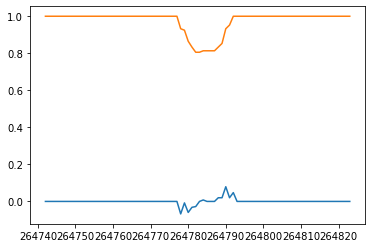

In [26]:
df_joined['brakeDiff'] = df_joined['brake'].diff()
pedCross = df_joined[(df_joined.nextPedRunning == True)]
dfNew = pedCross[(pedCross.session_id == 175.0) & (pedCross.scenario == 6.0) & (pedCross.pedId == 1.0)]
dfNew['brakeDiff'].plot()
dfNew['brake'].plot()

In [27]:
startReactionBrake = pedCross
finishReactionBrake = pedCross[(pedCross.brakeDiff < 0)]
finishReactionBrake.shape

(4711, 21)

In [28]:
firstRowPedCross = startReactionBrake.groupby(['session_id', 'scenario', 'pedId'], as_index=False).first()
firstRowPressBrake = finishReactionBrake.groupby(['session_id', 'scenario', 'pedId'], as_index=False).first()
firstRowPressBrake.shape
firstRowPedCross.shape

(531, 21)

In [29]:
reactionBrake = pd.merge(firstRowPedCross, firstRowPressBrake, on=['session_id','scenario','pedId'],how='left',suffixes=('_init','_fin'))
reactionBrake.head()

,session_id,scenario,pedId,time_init,Pos_X_init,Pos_Y_init,hadCollision_init,nextPedRunning_init,distancePed_init,speed_init,posPedX_init,posPedY_init,currentDistance_init,time2_init,steering_init,brake_init,throttle_init,acceleration_init,steeringOriginal_init,_merge_init,brakeDiff_init,time_fin,Pos_X_fin,Pos_Y_fin,hadCollision_fin,nextPedRunning_fin,distancePed_fin,speed_fin,posPedX_fin,posPedY_fin,currentDistance_fin,time2_fin,steering_fin,brake_fin,throttle_fin,acceleration_fin,steeringOriginal_fin,_merge_fin,brakeDiff_fin
0,144.0,1.0,1.0,2017-10-04 12:50:38.549538,-909.306458,80.473330,0.0,1.0,23.562530,7.754880,-885.689200,70.211080,1187.47815,2017-10-04 12:50:38.546530,0.495964,1.0,0.734127,0.084366,32503.0,both,0.0,2017-10-04 12:50:39.598329,-900.724600,78.646460,0.0,1.0,15.038287,8.946986,-885.665649,72.027790,1178.73486,2017-10-04 12:50:39.586297,0.477104,0.980163,0.948409,0.072344,31267.0,both,-0.019837
1,144.0,1.0,3.0,2017-10-04 12:50:47.530114,-839.965700,83.164460,0.0,1.0,39.895280,13.472353,-801.392639,87.102910,1119.30347,2017-10-04 12:50:47.548663,0.481437,1.0,0.880949,-0.004603,31551.0,both,0.0,2017-10-04 12:50:49.636729,-813.340149,91.523500,0.0,1.0,13.258779,13.034663,-801.989441,93.251990,1094.34827,2017-10-04 12:50:49.648762,0.533089,0.980163,0.948409,-0.009284,34936.0,both,-0.019837
2,144.0,1.0,15.0,2017-10-04 12:52:29.782335,-62.199753,40.680523,0.0,1.0,49.374313,25.585112,-20.775450,15.126913,357.44010,2017-10-04 12:52:29.792863,0.504952,1.0,0.230472,0.066917,33092.0,both,0.0,2017-10-04 12:52:29.861546,-60.378063,39.768070,0.0,1.0,47.374443,25.720684,-20.775450,15.126913,355.46260,2017-10-04 12:52:29.893130,0.504952,0.900801,0.445304,0.069757,33092.0,both,-0.099199
3,144.0,2.0,0.0,2017-10-04 12:57:42.500777,-933.749300,84.487495,0.0,1.0,7.474411,2.517837,-929.392000,77.257840,1212.21533,2017-10-04 12:57:42.544894,0.508186,1.0,0.837308,0.101637,33304.0,both,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,144.0,2.0,6.0,2017-10-04 12:58:05.786269,-666.426941,126.086250,0.0,1.0,48.876648,15.858500,-618.531900,115.657578,956.87360,2017-10-04 12:58:05.791282,0.528450,1.0,0.390616,0.183195,34632.0,both,0.0,2017-10-04 12:58:07.374997,-638.039900,128.005173,0.0,1.0,20.801785,19.957901,-618.279700,120.825100,929.67950,2017-10-04 12:58:07.393045,0.498405,0.996033,0.519844,0.081148,32663.0,both,-0.003967


In [30]:
reactionPressBrake = firstRowPedCross[['session_id', 'scenario', 'pedId', 'speed', 'distancePed']].copy()
reactionPressBrake['reaction_time'] = (pd.to_datetime(reactionBrake['time2_fin']) - pd.to_datetime(reactionBrake['time2_init'])).dt.total_seconds()
#reactionPressBrake = reactionPressBrake.fillna(reactionPressBrake.reaction_time.max())
reactionPressBrake = reactionPressBrake.dropna()
reactionPressBrake.head()

,session_id,scenario,pedId,speed,distancePed,reaction_time
0,144.0,1.0,1.0,7.754880,23.562530,1.039767
1,144.0,1.0,3.0,13.472353,39.895280,2.100099
2,144.0,1.0,15.0,25.585112,49.374313,0.100267
4,144.0,2.0,6.0,15.858500,48.876648,1.601763
5,144.0,2.0,12.0,11.275230,34.672924,1.802296


In [31]:
reactionPressBrake.shape

(454, 6)

In [32]:
reactionPressBrake.isnull().values.any()

False

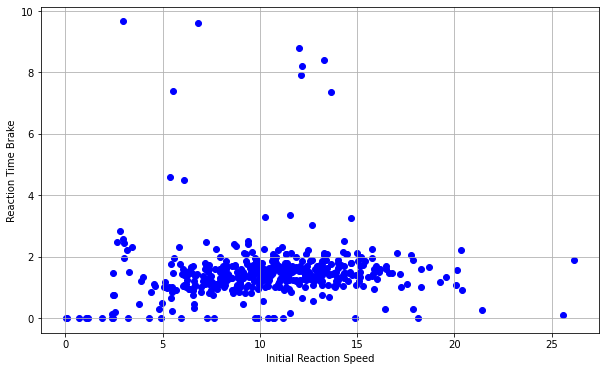

In [33]:
plt.figure(figsize=(10, 6))
plt.xlabel("Initial Reaction Speed")
plt.ylabel("Reaction Time Brake")

noHits = plt.scatter(reactionPressBrake['speed'], reactionPressBrake['reaction_time'], marker='o', c='b')

plt.grid(True)

plt.show()

In [34]:
reactionPressBrake.shape

(454, 6)

## Agressive driving measure: PKE

<AxesSubplot:>

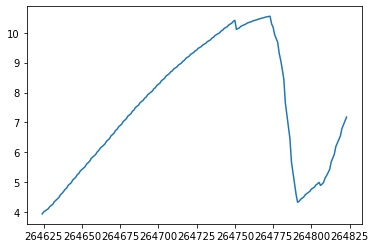

In [35]:
dfPKE = df_joined.copy()
dfNew = dfPKE[(dfPKE.session_id == 175.0) & (dfPKE.scenario == 6.0) & (dfPKE.pedId == 1.0)]
dfNew['speed'].plot(x = "Label")

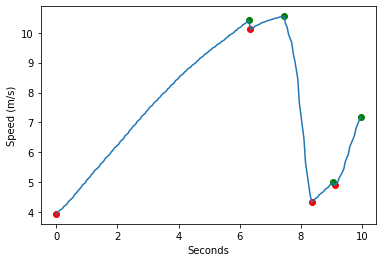

In [41]:
from scipy.signal import argrelextrema

df = dfNew.copy()
n=1 # number of points to be checked before and after 
# Find local peaks
df['min'] = df.iloc[argrelextrema(df.speed.values, np.less_equal, order=n)[0]]['speed']
df['max'] = df.iloc[argrelextrema(df.speed.values, np.greater_equal, order=n)[0]]['speed']

# Plot results
index = range(0, df['speed'].shape[0])
index = [number / 20 for number in index]
plt.scatter(index, df['min'], c='r')
plt.scatter(index, df['max'], c='g')
plt.plot(index, df['speed'])
plt.ylabel("Speed (m/s)")
plt.xlabel("Seconds")
plt.show()

In [84]:
df.head()

,time,session_id,scenario,Pos_X,Pos_Y,hadCollision,pedId,nextPedRunning,distancePed,speed,posPedX,posPedY,currentDistance,time2,steering,brake,throttle,acceleration,steeringOriginal,_merge,brakeDiff,min,max
264624,2017-10-10 12:26:19.670895,175.0,6.0,-958.071900,86.976036,0.0,1.0,0.0,72.838234,3.940402,-885.6892,70.21315,1236.63049,2017-10-10 12:26:19.695962,0.554833,1.0,0.880949,0.028599,36361.0,both,0.0,3.940402,NaN
264625,2017-10-10 12:26:19.747599,175.0,6.0,-957.767151,87.014770,0.0,1.0,0.0,72.557940,4.007564,-885.6892,70.21315,1236.33411,2017-10-10 12:26:19.736068,0.554833,1.0,0.880949,0.067161,36361.0,both,0.0,NaN,NaN
264626,2017-10-10 12:26:19.784197,175.0,6.0,-957.620600,87.032710,0.0,1.0,0.0,72.406900,4.041331,-885.6892,70.21315,1236.19153,2017-10-10 12:26:19.795728,0.554833,1.0,0.876982,0.033768,36361.0,both,0.0,NaN,NaN
264627,2017-10-10 12:26:19.824805,175.0,6.0,-957.457800,87.052020,0.0,1.0,0.0,72.263140,4.078692,-885.6892,70.21315,1236.03308,2017-10-10 12:26:19.835834,0.554833,1.0,0.876982,0.037361,36361.0,both,0.0,NaN,NaN
264628,2017-10-10 12:26:19.861903,175.0,6.0,-957.303833,87.069700,0.0,1.0,0.0,72.103400,4.113738,-885.6892,70.21315,1235.88300,2017-10-10 12:26:19.895994,0.554833,1.0,0.873014,0.035045,36361.0,both,0.0,NaN,NaN


In [85]:
import math

def aggressiveDriverPKE(df):
    vi = None
    acumulative = 0
    
    distance = ((pd.to_datetime(df['time2'].max()) - pd.to_datetime(df['time2'].min())).total_seconds())
    
    distance = float(distance) * df.speed.mean()
    
    df = df[(df['min'].notnull() | df['max'].notnull())]
    for index, row in df.iterrows():
        if (not math.isnan(row['min'])):
            vi = row['min']
        else:
            if (vi is None):
                continue
            else:
                if (not math.isnan(row['max'])):
                    vf = row['max']
                    acumulative += vf*vf - vi * vi
                    vi = None
                    vf = None

                    
    return acumulative/distance

In [86]:
n=1 # number of points to be checked before and after 
# Find local peaks
dfPKE = df_joined.copy()

dfPKE['min'] = dfPKE.iloc[argrelextrema(dfPKE.speed.values, np.less_equal, order=n)[0]]['speed']
dfPKE['max'] = dfPKE.iloc[argrelextrema(dfPKE.speed.values, np.greater_equal, order=n)[0]]['speed']

dfPKE = dfPKE[['session_id', 'scenario', 'pedId', 'min','max', 'time2', 'speed']]
total_PKE = dfPKE.groupby(['session_id', 'scenario', 'pedId']).apply(aggressiveDriverPKE).to_frame('PKE').reset_index()
total_PKE.head()

,session_id,scenario,pedId,PKE
0,144.0,1.0,1.0,1.105975
1,144.0,1.0,3.0,0.077727
2,144.0,1.0,15.0,5.013003
3,144.0,2.0,0.0,4.658734
4,144.0,2.0,6.0,4.199223


In [87]:
total_PKE.shape

(531, 4)

### Steering PKE


In [88]:
dfSteeringPKE = df_joined.copy()
dfSteeringPKE['min'] = dfSteeringPKE.iloc[argrelextrema(dfSteeringPKE.speed.values, np.less_equal, order=n)[0]]['steeringOriginal']
dfSteeringPKE['max'] = dfSteeringPKE.iloc[argrelextrema(dfSteeringPKE.speed.values, np.greater_equal, order=n)[0]]['steeringOriginal']

dfSteeringPKE = dfSteeringPKE[['session_id', 'scenario', 'pedId', 'time2', 'speed', 'min','max']]
total_steering_PKE = dfSteeringPKE.groupby(['session_id', 'scenario', 'pedId']).apply(aggressiveDriverPKE).to_frame('PKE_Steering').reset_index()

total_steering_PKE.head()

,session_id,scenario,pedId,PKE_Steering
0,144.0,1.0,1.0,-1.848506e+06
1,144.0,1.0,3.0,0.000000e+00
2,144.0,1.0,15.0,6.996196e+05
3,144.0,2.0,0.0,-4.952200e+06
4,144.0,2.0,6.0,-2.257110e+06


In [89]:
total_steering_PKE.shape

(531, 4)

## Backup PKE's

In [90]:
#total_PKE.to_csv('pke_fixed_time.csv', index=False)
#total_steering_PKE.to_csv('steering_pke_fixed_time.csv', index=False)

#total_PKE = pd.read_csv("pke_fixed_time.csv")
#total_steering_PKE = pd.read_csv("steering_pke_fixed_time.csv")


# Merge dataframes

In [108]:
df_suffix = pd.merge(means_cleaned, variance_cleaned, on=['session_id','scenario','pedId'],how='left',suffixes=('_total_mean','_total_var'))
df_suffix = pd.merge(df_suffix, max_speed, on=['session_id','scenario','pedId'],how='left',suffixes=('','_max'))
df_suffix = pd.merge(df_suffix, total_PKE, on=['session_id','scenario','pedId'],how='left')
df_suffix = pd.merge(df_suffix, total_steering_PKE, on=['session_id','scenario','pedId'],how='left')
df_suffix = pd.merge(df_suffix, reactionPressBrake, on=['session_id','scenario','pedId'],how='right',suffixes=('','_react'))
pd.options.display.max_columns = None
df_suffix.head()

,session_id,scenario,pedId,hadCollision,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,acceleration_total_var,speed,PKE,PKE_Steering,speed_react,distancePed,reaction_time
0,144.0,1.0,1.0,0.000,6.978462,0.493644,0.947244,0.813465,-0.000623,13.607109,0.000420,0.021339,0.032907,0.050404,11.669766,1.105975,-1.848506e+06,7.754880,23.562530,1.039767
1,144.0,1.0,3.0,0.000,7.045599,0.504890,0.875541,0.911211,-0.045255,33.663919,0.000176,0.065360,0.002429,0.068962,13.499710,0.077727,0.000000e+00,13.472353,39.895280,2.100099
2,144.0,1.0,15.0,0.075,10.263041,0.478319,0.817679,0.595013,-0.017068,76.873997,0.001610,0.105119,0.076302,0.705761,25.851397,5.013003,6.996196e+05,25.585112,49.374313,0.100267
3,144.0,2.0,6.0,0.030,7.264644,0.514681,0.801175,0.653184,-0.039171,54.852313,0.000417,0.031045,0.038022,0.079587,20.067612,4.199223,-2.257110e+06,15.858500,48.876648,1.601763
4,144.0,2.0,12.0,0.040,9.494161,0.505996,0.653854,0.808684,-0.143883,87.900514,0.000130,0.106531,0.056698,0.141090,29.754023,1.505738,7.974151e+05,11.275230,34.672924,1.802296


### Scenario Info

In [109]:
## Scenario 1 : Low pedestrian   | High Visibility | Low Traffic
## Scenario 2 : High pedestrian   | High Visibility | Low Traffic
## Scenario 3 : Normal pedestrian | Low Visibility | Low Traffic
## Scenario 4 : Normal pedestrian | High Visibility | Low Traffic 
## Scenario 6 : Normal pedestrian | High Visibility | High Traffic 
ped = {1: 0, 2: 2, 3: 1, 4: 1, 6: 1}
df_suffix['pedestriansLevel'] = df_suffix['scenario'].map(ped)

visibility = {1: 1, 2: 1, 3: 0, 4: 1, 6: 1}
df_suffix['visibilityLevel'] = df_suffix['scenario'].map(visibility)

traffic = {1: 0, 2: 0, 3: 0, 4: 0, 6: 1}
df_suffix['trafficLevel'] = df_suffix['scenario'].map(traffic)

### Info Participants

participantsData = pd.read_csv("InfoParticipants.csv", index_col=0) 
df_suffix = pd.merge(df_suffix, participantsData , on=['session_id'],how='left')

gender = {'M': 0, 'F': 1}
df_suffix['gender'] = df_suffix['gender'].map(gender)

job = {'Student': 0, 'PhD Student': 1, 'Researcher': 2, 'Project Coordinator': 3, 'Research Associate': 4, 'PA': 5, 'Events': 6}
df_suffix['job'] = df_suffix['job'].map(job)

LatestDegree = {'Bachelor': 0, 'Master': 1, 'PhD': 2, 'High School': 3, 'Uni Diploma': 4, 'University': 5}
df_suffix['LatestDegree'] = df_suffix['LatestDegree'].map(LatestDegree)

df_suffix.head()

In [110]:
def delete_common_columns(df):
    df.drop('session_id', axis=1, inplace=True, errors='ignore') 
    df.drop('scenario', axis=1, inplace=True, errors='ignore')
    df.drop('pedId', axis=1, inplace=True, errors='ignore')


#delete_common_columns(df_suffix)
df_scenario_cluster = df_suffix.copy()
#df_suffix.drop('scenario', axis=1, inplace=True, errors='ignore') 
df_suffix.rename(columns={'speed':'max_speed'}, inplace=True)


In [111]:
df_suffix.isnull().values.any()

df_suffix = df_suffix.dropna()

is_NaN = df_suffix.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_suffix[row_has_NaN]
rows_with_NaN

,session_id,scenario,pedId,hadCollision,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,acceleration_total_var,max_speed,PKE,PKE_Steering,speed_react,distancePed,reaction_time,pedestriansLevel,visibilityLevel,trafficLevel


In [112]:
df_suffix.shape

(454, 23)

## Mold Data

### Data Types

Inspect data types to see if there are any issues.  Data should be numeric.

In [113]:
df = df_suffix
#hadCollision_map = {True : 1, False : 0}
df['hadCollision'] = np.where(df['hadCollision'] == 0, 0, 1)

In [114]:

cols_at_end = ['hadCollision']
df = df[[c for c in df if c not in cols_at_end] 
        + [c for c in cols_at_end if c in df]]
df.head(5)

,session_id,scenario,pedId,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,acceleration_total_var,max_speed,PKE,PKE_Steering,speed_react,distancePed,reaction_time,pedestriansLevel,visibilityLevel,trafficLevel,hadCollision
0,144.0,1.0,1.0,6.978462,0.493644,0.947244,0.813465,-0.000623,13.607109,0.000420,0.021339,0.032907,0.050404,11.669766,1.105975,-1.848506e+06,7.754880,23.562530,1.039767,0,1,0,0
1,144.0,1.0,3.0,7.045599,0.504890,0.875541,0.911211,-0.045255,33.663919,0.000176,0.065360,0.002429,0.068962,13.499710,0.077727,0.000000e+00,13.472353,39.895280,2.100099,0,1,0,0
2,144.0,1.0,15.0,10.263041,0.478319,0.817679,0.595013,-0.017068,76.873997,0.001610,0.105119,0.076302,0.705761,25.851397,5.013003,6.996196e+05,25.585112,49.374313,0.100267,0,1,0,1
3,144.0,2.0,6.0,7.264644,0.514681,0.801175,0.653184,-0.039171,54.852313,0.000417,0.031045,0.038022,0.079587,20.067612,4.199223,-2.257110e+06,15.858500,48.876648,1.601763,2,1,0,1
4,144.0,2.0,12.0,9.494161,0.505996,0.653854,0.808684,-0.143883,87.900514,0.000130,0.106531,0.056698,0.141090,29.754023,1.505738,7.974151e+05,11.275230,34.672924,1.802296,2,1,0,1


In [115]:
def plot_corr(df, size=11):
    """
    Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot

    Displays:
        matrix of correlation between columns.  Blue-cyan-yellow-red-darkred => less to more correlated
                                                0 ------------------>  1
                                                Expect a darkred line running from top left to bottom right
    """

    corr = df.corr()    # data frame correlation function
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)   # color code the rectangles by correlation value
    plt.xticks(range(len(corr.columns)), corr.columns)  # draw x tick marks
    plt.yticks(range(len(corr.columns)), corr.columns)  # draw y tick marks

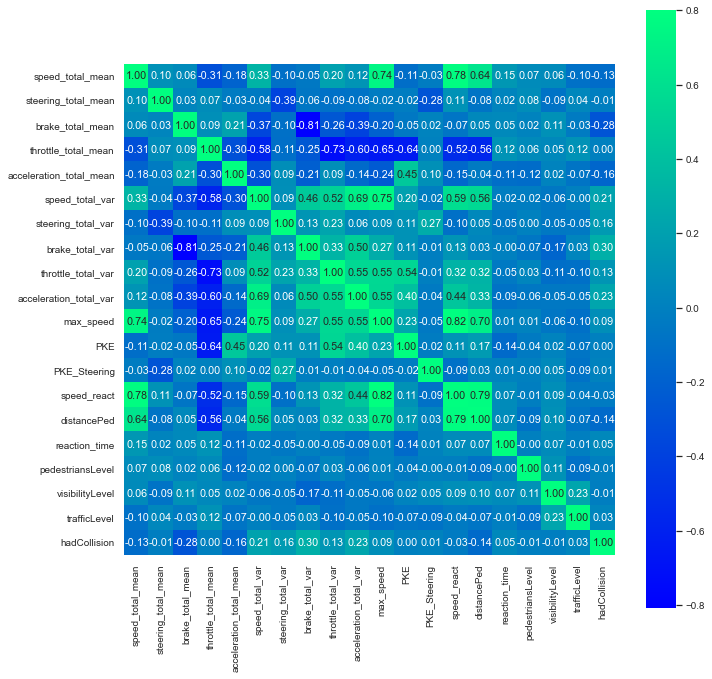

In [116]:
import seaborn as sns
df_corr = df.copy()
delete_common_columns(df_corr)
corrmat = df_corr.corr()
f, ax = plt.subplots(figsize=(11,11))
sns.set(font_scale=0.9)
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt='.2f', cmap="winter")
plt.show()

### Backup merge data

In [117]:
df.to_csv('featured_data_with_fixed_time.csv', index=False)